In [1]:
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor) 
import copy

from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *
from research_exp_utils import *
from rct_data_generator import generate_host_and_mirror


/Users/jake/Python/causal_prospective_merge/.conda/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536958/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/jake/Python/causal_prospective_merge/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)

n_rct_before_split = 10**6
n_host = 200
sigma_prior = 1
sigma_rand_error = 1

power_x, power_x_t = 1, 1
causal_param_first_index = 4
outcome_function = lambda X, T, eps: 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * X[:,2] + 4 * T + 2* X[:,0]*T + 2* X[:,1]*T + 0* X[:,2]*T + eps 
std_true_y = 1 # Standard deviation for the true Y

X0 = np.random.beta(12, 3, size= n_rct_before_split)
X1 = np.random.normal(loc=4, scale=1, size=n_rct_before_split)
X2 = np.random.beta(1, 7, size=n_rct_before_split)
x_distributions= {0: X0, 1: X1, 2:X2}

p_assigned_to_host = lambda X_0, X_1, T, eps: sigmoid(1 + 2*X_0 - X_1 + 2*T + eps)
p_assigned_to_cand2 = lambda X_0, X_1, T, eps: sigmoid(1 + 2*X_0 - X_1 + 2*T + eps)
# p_assigned_to_cand2 = lambda X_0, X_1, T, eps: sigmoid(1 - 2*X_0 + eps)

Simulation parameters

In [3]:
# Prior parameters for Bayesian update on host
prior_mean = np.array([0, 1, 0, 0, 1, 0, 0, 0])
beta_0, sigma_0_sq,inv_cov_0 = prior_mean, sigma_rand_error**2,1/sigma_prior*np.eye(len(prior_mean)) 
prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq,"inv_cov_0":inv_cov_0}

# Hyperparameters for Bayesian update on host
warmup_steps = 50
max_tree_depth = 5

# Number of samples used to estimate outer expectation
n_samples_for_expectation = 30
m_samples_for_expectation = 500

# Incorporating sqrt constraint into MCMC samples
n_mc = (n_samples_for_expectation * (m_samples_for_expectation+1)) 

### 2. EIG closed form for varying sample sizes

In [4]:
n_both_candidates_list = [200, 500, 1000]
proportion = 1 #n_cand2 = prorportion * n_both_candidates_list
std_true_y = 1
n_seeds=10

text_l1 ='p_assigned_to_host=p_assigned_to_cand2, n_samples_for_expectation = 30,'
text_l2 = 'm_samples_for_expectation = 500, n_host = 200, sigma_prior = 1, sigma_rand_error = 1,'
text_l3 = 'outcome_function = 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * X[:,2] + 1 * T + 2* X[:,0]*T + 2* X[:,1]*T +2* X[:,2]*T  +eps'

In [5]:
EIG_obs_closed_form_across_seeds, EIG_caus_closed_form_across_seeds = [], []

for i in range (n_seeds):
    EIG_obs_closed_form, EIG_caus_closed_form = eig_closed_form_varying_sample_size(n_both_candidates_list, proportion, n_rct_before_split, x_distributions, \
                                        p_assigned_to_cand2, n_host, power_x, power_x_t, outcome_function, std_true_y, \
                                        causal_param_first_index, sigma_rand_error, prior_hyperparameters, n_mc)
    if len(EIG_obs_closed_form_across_seeds)==0:
        EIG_obs_closed_form_across_seeds= EIG_obs_closed_form
        EIG_caus_closed_form_across_seeds = EIG_caus_closed_form
    else:
        EIG_obs_closed_form_across_seeds = np.vstack((EIG_obs_closed_form_across_seeds, EIG_obs_closed_form))
        EIG_caus_closed_form_across_seeds = np.vstack((EIG_caus_closed_form_across_seeds, EIG_caus_closed_form))

For a sample size in mirror and host of 200
Percentage of treated in host: 67.66917293233082%
Percentage of treated in mirror: 34.0%
Percentage of treated in cand2: 70.5%
For a sample size in mirror and host of 500
Percentage of treated in host: 70.0%
Percentage of treated in mirror: 38.0%
Percentage of treated in cand2: 70.0%
For a sample size in mirror and host of 1000
Percentage of treated in host: 63.5%
Percentage of treated in mirror: 35.7%
Percentage of treated in cand2: 70.9%
For a sample size in mirror and host of 200
Percentage of treated in host: 78.48101265822785%
Percentage of treated in mirror: 32.5%
Percentage of treated in cand2: 70.0%
For a sample size in mirror and host of 500
Percentage of treated in host: 70.0%
Percentage of treated in mirror: 39.4%
Percentage of treated in cand2: 68.8%
For a sample size in mirror and host of 1000
Percentage of treated in host: 70.0%
Percentage of treated in mirror: 32.5%
Percentage of treated in cand2: 69.1%
For a sample size in mir

FileNotFoundError: [Errno 2] No such file or directory: '/Users/lucile/causal_info_gain/plots/eig_obs_2024-03-20_15:25:25.pdf'

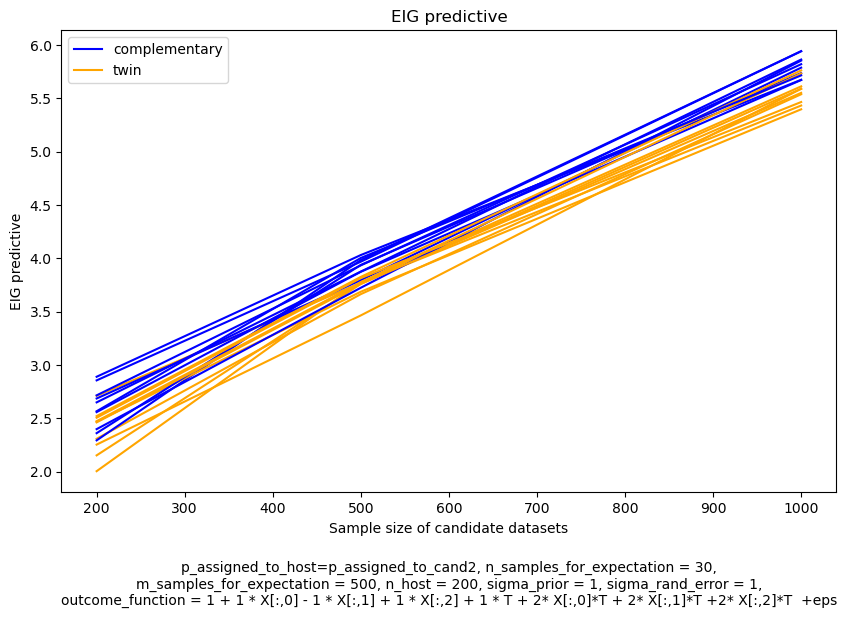

In [6]:
path_obs = '/Users/lucile/causal_info_gain/plots/eig_obs'
plot_array(n_both_candidates_list, EIG_obs_closed_form_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG predictive'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3, title= 'EIG predictive', save=path_obs)

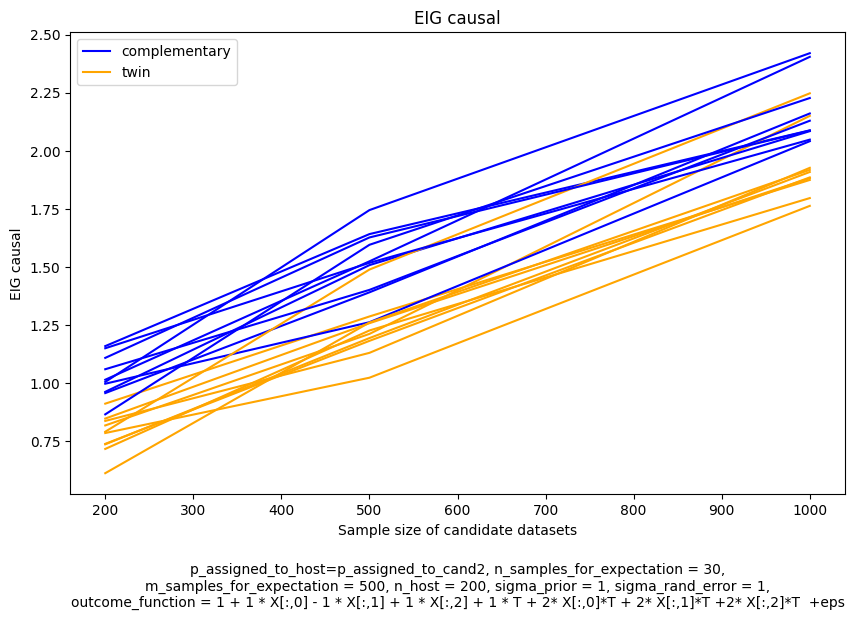

In [ ]:
path_caus = '/Users/lucile/causal_info_gain/plots/eig_caus'

plot_array(n_both_candidates_list, EIG_caus_closed_form_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG causal'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3, title= 'EIG causal', save=path_caus)

### 2. EIG from samples for varying sample sizes

In [7]:
n_non_causal_expectation = 100
n_samples_for_expectation = 2 
m_samples_for_expectation = 3
n_causal_outer_exp=40
EIG_obs_samples, EIG_caus_samples = eig_from_samples_varying_sample_size(n_both_candidates_list, proportion, n_rct_before_split, x_distributions, \
                                        p_assigned_to_cand2, n_host, power_x, power_x_t, outcome_function, std_true_y, \
                                        causal_param_first_index, sigma_rand_error, prior_hyperparameters, n_samples_for_expectation, m_samples_for_expectation, n_non_causal_expectation, n_causal_outer_exp)

For a sample size in mirror and host of 200
Percentage of treated in host: 74.82993197278911%
Percentage of treated in mirror: 34.0%
Percentage of treated in cand2: 75.0%
For a sample size in mirror and host of 500
Percentage of treated in host: 68.5%
Percentage of treated in mirror: 34.2%
Percentage of treated in cand2: 70.8%
For a sample size in mirror and host of 1000
Percentage of treated in host: 73.0%
Percentage of treated in mirror: 35.2%
Percentage of treated in cand2: 69.7%


In [ ]:
plot_array(n_both_candidates_list, EIG_obs_samples, names=['mirror','cand2'], title= 'EIG obs from sample')

In [ ]:
plot_array(n_both_candidates_list, EIG_obs_samples, names=['mirror','cand2'], title= 'EIG obs from sample')

In [ ]:
def eig_closed_form_varying_sample_size(n_both_candidates_list, proportion, n_rct_before_split, x_distributions, \
                                        p_assigned_to_cand2, n_host, power_x, power_x_t, outcome_function, std_true_y, \
                                        causal_param_first_index, sigma_rand_error, prior_hyperparameters, n_mc):

    EIG_obs_closed_form_mirror, EIG_obs_closed_form_cand2 = [], []
    EIG_caus_closed_form_mirror, EIG_caus_closed_form_cand2 = [], []

    for length in n_both_candidates_list:

        X_rct, T_rct = generate_rct(n_rct_before_split, x_distributions)
        design_data_host, design_data_mirror = generate_host_and_mirror(X_rct, T_rct, p_assigned_to_cand2, n_host, length, power_x, power_x_t, outcome_function, std_true_y)


        pre_X_cand2, pre_T_cand2 = generate_rct(n_rct_before_split, x_distributions)
        design_data_cand2 = generate_cand2(pre_X_cand2, pre_T_cand2, p_assigned_to_cand2, proportion*length, \
                                            power_x, power_x_t, outcome_function, std_true_y)

        X_host = design_data_host.drop(columns=['Y'])
        X_mirror = design_data_mirror.drop(columns=['Y'])
        X_cand2 = design_data_cand2.drop(columns=['Y'])

        percent_treated_host = 100*sum(X_host["T"])/len(X_host)
        percent_treated_mirror = 100*sum(X_mirror["T"])/len(X_mirror)
        percent_treated_cand2 = 100*sum(X_cand2["T"])/len(X_cand2)

        print("For a sample size in mirror and host of "+str(length))
        print(f'Percentage of treated in host: {percent_treated_host}%')
        print(f'Percentage of treated in mirror: {percent_treated_mirror}%')
        print(f'Percentage of treated in cand2: {percent_treated_cand2}%')
              
        bayes_reg = BayesianLinearRegression(prior_hyperparameters)

        ### Bayesian update on host data using closed form 
        X_host, Y_host= design_data_host.drop(columns=['Y']), design_data_host['Y']
        post_host_parameters = bayes_reg.fit(X_host, Y_host)
        beta_post_host_vec = post_host_parameters['posterior_mean'].flatten()  # Extract posterior mean
        cov_matrix_post_host = post_host_parameters['posterior_cov_matrix']
        

        # X_torch, Y_torch = torch.tensor(X_host.values), torch.tensor(Y_host.values)
        # mcmc_host = MCMC_Bayesian_update(X_torch = X_torch, Y_torch = Y_torch, model =model_normal,
        #             mu_0= beta_0, sigma_prior = sigma_prior, sigma_rand_error = sigma_rand_error,
        #             sigma_rand_error_fixed = True, n_mcmc = n_mc, warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)

        X_mirror_arr, X_cand2_arr = X_mirror.values, X_cand2.values

        EIG_obs_one_n_mirror = compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host,sigma_rand_error)
        EIG_obs_one_n_cand2 = compute_EIG_obs_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error)

        EIG_obs_closed_form_mirror.append(EIG_obs_one_n_mirror)    
        EIG_obs_closed_form_cand2.append(EIG_obs_one_n_cand2)

        EIG_caus_one_n_mirror = compute_EIG_causal_closed_form(X_mirror_arr, cov_matrix_post_host, sigma_rand_error, causal_param_first_index)
        EIG_caus_one_n_cand2 = compute_EIG_causal_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error, causal_param_first_index)

        EIG_caus_closed_form_mirror.append(EIG_caus_one_n_mirror)    
        EIG_caus_closed_form_cand2.append(EIG_caus_one_n_cand2)
    
    EIG_obs_closed_form = np.vstack((EIG_obs_closed_form_mirror,EIG_obs_closed_form_cand2 ))
    EIG_caus_closed_form = np.vstack((EIG_caus_closed_form_mirror,EIG_caus_closed_form_cand2 ))

    return EIG_obs_closed_form, EIG_caus_closed_form

In [ ]:
n_both_candidates_list, proportion, n_rct_before_split, x_distributions, \
                                        p_assigned_to_cand2, n_host, power_x, power_x_t, outcome_function, std_true_y, \
                                        causal_param_first_index, sigma_rand_error

([200, 500, 1000],
 1,
 1000000,
 {0: array([0.74610574, 0.73487282, 0.79616725, ..., 0.92540498, 0.80857553,
         0.7028223 ]),
  1: array([5.34318842, 2.86069435, 5.14093007, ..., 5.85738327, 4.23812178,
         4.96026851]),
  2: array([0.15068246, 0.09855078, 0.02114523, ..., 0.00413985, 0.01837222,
         0.15026603])},
 <function __main__.<lambda>(X_0, X_1, T, eps)>,
 200,
 1,
 1,
 <function __main__.<lambda>(X, T, eps)>,
 1,
 4,
 1)

In [ ]:
def eig_from_samples_varying_sample_size(n_both_candidates_list, proportion, n_rct_before_split, x_distributions, \
                                        p_assigned_to_cand2, n_host, power_x, power_x_t, outcome_function, std_true_y, \
                                        causal_param_first_index, sigma_rand_error, prior_hyperparameters, n_mc, n_non_causal_expectation=100, n_causal_outer_exp=40):

    EIG_obs_samples_mirror, EIG_obs_samples_cand2 = [], []
    EIG_caus_samples_mirror, EIG_caus_samples_cand2 = [], []

    for length in n_both_candidates_list:

        X_rct, T_rct = generate_rct(n_rct_before_split, x_distributions)
        design_data_host, design_data_mirror = generate_host_and_mirror(X_rct, T_rct, p_assigned_to_cand2, n_host, length, power_x, power_x_t, outcome_function, std_true_y)


        pre_X_cand2, pre_T_cand2 = generate_rct(n_rct_before_split, x_distributions)
        design_data_cand2 = generate_cand2(pre_X_cand2, pre_T_cand2, p_assigned_to_cand2, proportion*length, \
                                            power_x, power_x_t, outcome_function, std_true_y)

        X_host = design_data_host.drop(columns=['Y'])
        X_mirror = design_data_mirror.drop(columns=['Y'])
        X_cand2 = design_data_cand2.drop(columns=['Y'])

        percent_treated_host = 100*sum(X_host["T"])/len(X_host)
        percent_treated_mirror = 100*sum(X_mirror["T"])/len(X_mirror)
        percent_treated_cand2 = 100*sum(X_cand2["T"])/len(X_cand2)

        print("For a sample size in mirror and host of "+str(length))
        print(f'Percentage of treated in host: {percent_treated_host}%')
        print(f'Percentage of treated in mirror: {percent_treated_mirror}%')
        print(f'Percentage of treated in cand2: {percent_treated_cand2}%')
              
        bayes_reg = BayesianLinearRegression(prior_hyperparameters)

        ### Bayesian update on host data using closed form 
        X_host, Y_host= design_data_host.drop(columns=['Y']), design_data_host['Y']
        post_host_parameters = bayes_reg.fit(X_host, Y_host)
        beta_post_host = post_host_parameters['posterior_mean'].flatten()  # Extract posterior mean
        cov_matrix_post_host = post_host_parameters['posterior_cov_matrix']

        # ## Bayesian update using the host dataset
        # mcmc_host = MCMC_Bayesian_update(X_torch =X_torch, Y_torch = Y_torch, model = model_normal,
        #             mu_0= beta_0, sigma_prior = sigma_prior, sigma_rand_error = sigma_rand_error,
        #             sigma_rand_error_fixed = True, n_mcmc = n_mcmc, warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
        # beta_post_host = pd.DataFrame(mcmc_host.get_samples())
        
        X_mirror_arr, X_cand2_arr = X_mirror.values, X_cand2.values
        X_torch, Y_torch = torch.tensor(X_host.values), torch.tensor(Y_host.values)

        Y_pred_mirror = predict_with_all_sampled_linear(beta_post_host, X_mirror_arr)
        pred_list_mirror = predictions_in_EIG_obs_form(Y_pred_mirror, n_samples_for_expectation, m_samples_for_expectation)   

        Y_pred_cand2 = predict_with_all_sampled_linear(beta_post_host, X_cand2_arr)
        pred_list_cand2 = predictions_in_EIG_obs_form(Y_pred_cand2, n_samples_for_expectation, m_samples_for_expectation)  
        
        EIG_obs_one_n_mirror = compute_EIG_obs_from_samples(pred_list_mirror, sigma_rand_error)
        EIG_obs_one_n_cand2 = compute_EIG_obs_from_samples(pred_list_cand2, sigma_rand_error)

        EIG_obs_samples_mirror.append(EIG_obs_one_n_mirror)    
        EIG_obs_samples_cand2.append(EIG_obs_one_n_cand2)

        ## causal

        sample_func = return_causal_samp_func_linear(X=X_torch,Y=Y_torch,causal_param_first_index=3,mu_0=beta_0,sigma_prior = sigma_prior,
                                            sigma_rand_error = sigma_rand_error,sigma_rand_error_fixed = True,warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
        
        pred_func_mirror = lambda beta: beta @ (X_mirror).T
        pred_func_cand2 = lambda beta: beta @ (X_cand2).T

        pred_in_causal_form_mirror = predictions_in_EIG_causal_form(pred_func_mirror, n_non_causal_expectation, causal_param_first_index, theta_samples=beta_post_host.values[:n_causal_outer_exp], theta_sampling_function=sample_func)
        pred_in_causal_form_cand2 = predictions_in_EIG_causal_form(pred_func_cand2, n_non_causal_expectation, causal_param_first_index, theta_samples=beta_post_host.values[:n_causal_outer_exp], theta_sampling_function=sample_func)


        EIG_caus_one_n_mirror = compute_EIG_causal_from_samples(pred_list_mirror,pred_in_causal_form_mirror, sigma_rand_error)
        EIG_caus_one_n_cand2 = compute_EIG_causal_from_samples(pred_list_cand2,pred_in_causal_form_cand2, sigma_rand_error)

        EIG_caus_samples_mirror.append(EIG_caus_one_n_mirror)    
        EIG_caus_samples_cand2.append(EIG_caus_one_n_cand2)

    EIG_obs_samples = np.vstack((EIG_obs_samples_mirror, EIG_obs_samples_cand2 ))
    EIG_caus_samples = np.vstack((EIG_caus_samples_mirror, EIG_caus_samples_cand2 ))

    return EIG_obs_samples, EIG_caus_samples

In [ ]:
EIG_obs_samples_mirror, EIG_obs_samples_cand2 = [], []
EIG_caus_samples_mirror, EIG_caus_samples_cand2 = [], []

for length in n_both_candidates_list:

    X_rct, T_rct = generate_rct(n_rct_before_split, x_distributions)
    design_data_host, design_data_mirror = generate_host_and_mirror(X_rct, T_rct, p_assigned_to_cand2, n_host, length, power_x, power_x_t, outcome_function, std_true_y)


    pre_X_cand2, pre_T_cand2 = generate_rct(n_rct_before_split, x_distributions)
    design_data_cand2 = generate_cand2(pre_X_cand2, pre_T_cand2, p_assigned_to_cand2, proportion*length, \
                                        power_x, power_x_t, outcome_function, std_true_y)

    X_host = design_data_host.drop(columns=['Y'])
    X_mirror = design_data_mirror.drop(columns=['Y'])
    X_cand2 = design_data_cand2.drop(columns=['Y'])

    percent_treated_host = 100*sum(X_host["T"])/len(X_host)
    percent_treated_mirror = 100*sum(X_mirror["T"])/len(X_mirror)
    percent_treated_cand2 = 100*sum(X_cand2["T"])/len(X_cand2)

    print("For a sample size in mirror and host of "+str(length))
    print(f'Percentage of treated in host: {percent_treated_host}%')
    print(f'Percentage of treated in mirror: {percent_treated_mirror}%')
    print(f'Percentage of treated in cand2: {percent_treated_cand2}%')
            
    bayes_reg = BayesianLinearRegression(prior_hyperparameters)

    ### Bayesian update on host data using closed form 
    X_host, Y_host= design_data_host.drop(columns=['Y']), design_data_host['Y']
    post_host_parameters = bayes_reg.fit(X_host, Y_host)
    beta_post_host_vec = post_host_parameters['posterior_mean'].flatten()  # Extract posterior mean
    cov_matrix_post_host = post_host_parameters['posterior_cov_matrix']

    n_samples = n_samples_for_expectation*(m_samples_for_expectation+1)
    beta_post_host_samples = bayes_reg.posterior_sample(n_samples=n_samples)
    
    X_mirror_arr, X_cand2_arr = X_mirror.values, X_cand2.values
    X_torch, Y_torch = torch.tensor(X_host.values), torch.tensor(Y_host.values)

    Y_pred_mirror = predict_with_all_sampled_linear(beta_post_host_samples, X_mirror_arr)
    pred_list_mirror = predictions_in_EIG_obs_form(Y_pred_mirror, n_samples_for_expectation, m_samples_for_expectation)   

    Y_pred_cand2 = predict_with_all_sampled_linear(beta_post_host_samples, X_cand2_arr)
    pred_list_cand2 = predictions_in_EIG_obs_form(Y_pred_cand2, n_samples_for_expectation, m_samples_for_expectation)  
    
    EIG_obs_one_n_mirror = compute_EIG_obs_from_samples(pred_list_mirror, sigma_rand_error)
    EIG_obs_one_n_cand2 = compute_EIG_obs_from_samples(pred_list_cand2, sigma_rand_error)

    EIG_obs_samples_mirror.append(EIG_obs_one_n_mirror)    
    EIG_obs_samples_cand2.append(EIG_obs_one_n_cand2)

    ## causal

    sample_func = bayes_reg.return_conditional_sample_function(causal_param_first_index)
    
    pred_func_mirror = lambda beta: beta @ (X_mirror).T
    pred_func_cand2 = lambda beta: beta @ (X_cand2).T

    pred_in_causal_form_mirror = predictions_in_EIG_causal_form(pred_func=pred_func_mirror, theta_samples=beta_post_host_samples, theta_sampling_function=sample_func,n_non_causal_expectation= n_non_causal_expectation,causal_param_first_index= causal_param_first_index)
    pred_in_causal_form_cand2 = predictions_in_EIG_causal_form(pred_func=pred_func_cand2, theta_samples=beta_post_host_samples, theta_sampling_function=sample_func,n_non_causal_expectation= n_non_causal_expectation,causal_param_first_index= causal_param_first_index)


    EIG_caus_one_n_mirror = compute_EIG_causal_from_samples(pred_list_mirror,pred_in_causal_form_mirror, sigma_rand_error)
    EIG_caus_one_n_cand2 = compute_EIG_causal_from_samples(pred_list_cand2,pred_in_causal_form_cand2, sigma_rand_error)

    EIG_caus_samples_mirror.append(EIG_caus_one_n_mirror)    
    EIG_caus_samples_cand2.append(EIG_caus_one_n_cand2)

EIG_obs_samples = np.vstack((EIG_obs_samples_mirror, EIG_obs_samples_cand2 ))
EIG_caus_samples = np.vstack((EIG_caus_samples_mirror, EIG_caus_samples_cand2 ))

For a sample size in mirror and host of 200
Percentage of treated in host: 70.51282051282051%
Percentage of treated in mirror: 33.5%
Percentage of treated in cand2: 74.0%
For a sample size in mirror and host of 500
Percentage of treated in host: 71.5%
Percentage of treated in mirror: 31.0%
Percentage of treated in cand2: 66.2%
For a sample size in mirror and host of 1000
Percentage of treated in host: 69.0%
Percentage of treated in mirror: 33.7%
Percentage of treated in cand2: 71.1%


In [ ]:
pred_func=pred_func_mirror
theta_samples=beta_post_host_samples
theta_sampling_function=sample_func
n_non_causal_expectation= n_non_causal_expectation
causal_param_first_index= causal_param_first_index

In [ ]:
paired_predictions = []

for theta in theta_samples:
    theta_causal = theta[causal_param_first_index:]
    thetas_samples_non_causal = theta_sampling_function(theta_causal, n_non_causal_expectation)
    predictions = [pred_func(np.concatenate([np.array(theta_noncausal),np.array(theta_causal)])) for theta_noncausal in thetas_samples_non_causal]
    paired_predictions.append((pred_func(theta), predictions))

TypeError: 'numpy.float64' object cannot be interpreted as an integer